## Case Study #3 - Foodie-Fi

#### Problem Statement
Subscription based businesses are super popular and Danny realised that there was a large gap in the market - he wanted to create a new streaming service that only had food related content - something like Netflix but with only cooking shows!

Danny finds a few smart friends to launch his new startup Foodie-Fi in 2020 and started selling monthly and annual subscriptions, giving their customers unlimited on-demand access to exclusive food videos from around the world!

Danny created Foodie-Fi with a data driven mindset and wanted to ensure all future investment decisions and new features were decided using data. This case study focuses on using subscription style digital data to answer important business questions.

Danny has shared the data design for Foodie-Fi and also short descriptions on each of the database tables - our case study focuses on only 2 tables but there will be a challenge to create a new table for the Foodie-Fi team.

#### Entity Relationship Diagram

![week3.png](week3.png)

Import modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
pd.set_option('display.max_columns', None)

Initialize SQL

In [2]:
conn = sql.connect("week3.db")
cursor = conn.cursor() 
if os.stat("week3.db").st_size == 0:
    with open('week3-sql.txt','r') as file:
        script = file.read()
        script = script.replace('\n', ' ')
    cursor.executescript(script)

Verify tables

In [3]:
query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor.execute(query)
tables = [table[0] for table in cursor.fetchall()]
tables
print(f'The tables in the database are: {', '.join(tables)}')

The tables in the database are: plans, subscriptions


Fetch table information

In [4]:
for table in tables:
    print("=================================")
    print(f'Table [{table}]')
    df = pd.read_sql_query(f'SELECT * FROM {table}', conn)
    print(f'Dimensions: {df.shape[0]} rows x {df.shape[1]} columns\n')
    print(df.head())
    info_df = pd.DataFrame.from_dict({'Datatypes':df.dtypes, 'NULL count':df.isna().sum()})
    print()
    print(info_df)
    print()

Table [plans]
Dimensions: 5 rows x 3 columns

   plan_id      plan_name  price
0        0          trial    0.0
1        1  basic monthly    9.9
2        2    pro monthly   19.9
3        3     pro annual  199.0
4        4          churn    NaN

          Datatypes  NULL count
plan_id       int64           0
plan_name    object           0
price       float64           1

Table [subscriptions]
Dimensions: 2650 rows x 3 columns

   customer_id  plan_id  start_date
0            1        0  2020-08-01
1            1        1  2020-08-08
2            2        0  2020-09-20
3            2        3  2020-09-27
4            3        0  2020-01-13

            Datatypes  NULL count
customer_id     int64           0
plan_id         int64           0
start_date     object           0



In [5]:
def query(stmt: str):
    """Executes a given SQL statement and returns a Pandas DataFrame given the results.
    
    Parameters
    ----------
    stmt: str
        The SQL statement to be executed
    """
    global conn
    result = pd.read_sql_query(stmt, conn)
    return result

## Case Study Questions

This case study is split into an initial data understanding question before diving straight into data analysis questions before finishing with 1 single extension challenge.

**A. Customer Journey**

Q1: Based off the 8 sample customers provided in the sample from the subscriptions table, write a brief description about each customer’s onboarding journey.

Try to keep it as short as possible - you may also want to run some sort of join to make your explanations a bit easier!

- The IDs of the sample customers were: 1, 2, 11, 13, 15, 16, 18, 19

In [6]:
# Create a table where each row is a customer and the columns represent the start dates of their plans
query('''
    WITH customers (customer_id) as (VALUES (1),(2),(11),(13),(15),(16),(18),(19)),
    
    p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
        AND customer_id IN customers
    ),
    p1_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 1
        AND customer_id IN customers
    ),
    p2_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 2
        AND customer_id IN customers
    ),
    p3_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 3
        AND customer_id IN customers
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
        AND customer_id IN customers
    )
      
    SELECT customers.customer_id,
        p0.start_date as trial_date,
        p1.start_date as basic_monthly_date,
        p2.start_date as pro_monthly_date,
        p3.start_date as pro_annual_date,
        p4.start_date as churn_date
    FROM customers
        LEFT JOIN p0_dates p0 USING (customer_id)
        LEFT JOIN p1_dates p1 USING (customer_id)
        LEFT JOIN p2_dates p2 USING (customer_id)
        LEFT JOIN p3_dates p3 USING (customer_id)
        LEFT JOIN p4_dates p4 USING (customer_id)
''')

,customer_id,trial_date,basic_monthly_date,pro_monthly_date,pro_annual_date,churn_date
0,1,2020-08-01,2020-08-08,None,None,None
1,2,2020-09-20,None,None,2020-09-27,None
2,11,2020-11-19,None,None,None,2020-11-26
3,13,2020-12-15,2020-12-22,2021-03-29,None,None
4,15,2020-03-17,None,2020-03-24,None,2020-04-29
5,16,2020-05-31,2020-06-07,None,2020-10-21,None
6,18,2020-07-06,None,2020-07-13,None,None
7,19,2020-06-22,None,2020-06-29,2020-08-29,None


- Customer 1 started his free trial on Aug 1, 2020 and subscribed to the basic monthly plan 7 days after until present.
- Customer 2 started his free trial on Sep 20, 2020 and subscribed to the pro annual plan 7 days after until present.
- Customer 15 started his free trial on Mar 17, 2020 and subscribed to the pro monthly plan 7 days after, but churned on Apr 29, 2020.

**B. Data Analysis Questions**

Q2: How many customers has Foodie-Fi ever had?

In [7]:
query('''
    SELECT COUNT(DISTINCT customer_id) AS num_customers
    FROM subscriptions;
''')

,num_customers
0,1000


Q3: What is the monthly distribution of trial plan start_date values for our dataset - use the start of the month as the group by value

In [8]:
q3_df = query('''
    SELECT
        strftime('%m',start_date) AS month_date, -- Cast start_date as month in numerical format
        COUNT(s.customer_id) AS trial_plan_subscriptions
    FROM subscriptions AS s
        JOIN plans p
        ON s.plan_id = p.plan_id
    WHERE s.plan_id = 0 -- Trial plan ID is 0
    GROUP BY month_date
    ORDER BY month_date;
''')
q3_df

,month_date,trial_plan_subscriptions
0,01,88
1,02,68
2,03,94
3,04,81
4,05,88
5,06,79
6,07,89
7,08,88
8,09,87
9,10,79


<Axes: xlabel='month_date', ylabel='trial_plan_subscriptions'>

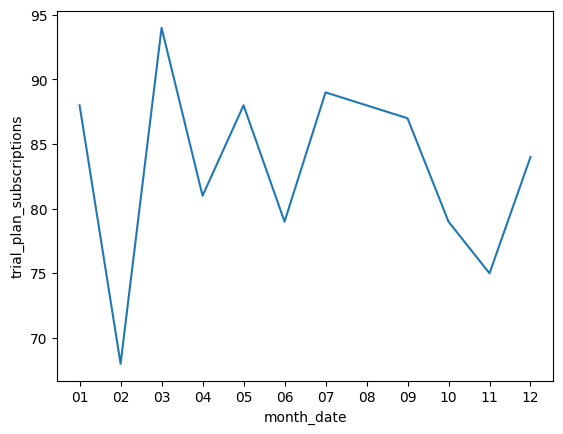

In [12]:
sns.lineplot(data=q3_df,x='month_date',y='trial_plan_subscriptions')

Q4: What is the customer count and percentage of customers who have churned rounded to 1 decimal place?

In [30]:
query('''
    WITH num_customers AS(
        SELECT COUNT(DISTINCT customer_id) AS num_customers
        FROM subscriptions 
    )
    SELECT
        COUNT(DISTINCT customer_id) AS churned_count,
        ROUND(COUNT(DISTINCT customer_id) / CAST(num_customers AS FLOAT) * 100,1) || ' %' AS percentage
        FROM subscriptions, num_customers
        WHERE plan_id = 4
''')

,churned_count,percentage
0,307,30.7 %


Bonus: Visualizing the distribution of number of days taken for customers to churn:

In [16]:
q4b_df = query('''
    WITH p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
    )
    SELECT
        p4.customer_id,
        julianday(p4.start_date) - julianday(p0.start_date) AS length
    FROM
        p4_dates p4
        INNER JOIN p0_dates p0 ON p4.customer_id = p0.customer_id
''')
q4b_df

,customer_id,length
0,4,95.0
1,6,65.0
2,11,7.0
3,15,43.0
4,21,236.0
...,...,...
302,993,7.0
303,996,26.0
304,997,110.0
305,999,39.0


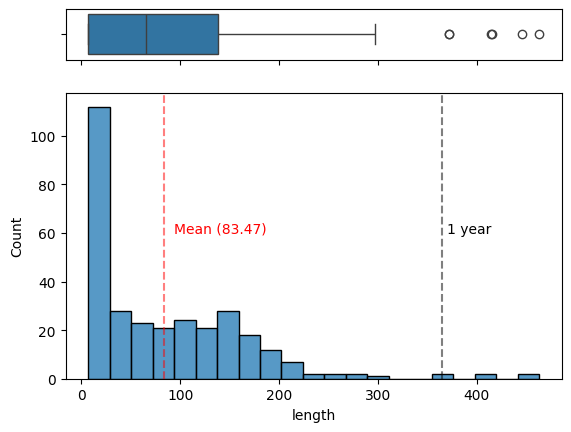

In [47]:
mean_length = q4b_df['length'].mean()
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(q4b_df["length"], orient="h", ax=ax_box)
sns.histplot(data=q4b_df, x="length", bins=int(np.sqrt(q4b_df['length'].max())), ax=ax_hist)
plt.axvline(x = 365, color = 'black', alpha=0.5, linestyle='dashed')
plt.text(370,60, '1 year', color='black')
plt.axvline(x = mean_length, color='red', alpha=0.5, linestyle='dashed')
plt.text(mean_length+10, 60, f'Mean ({mean_length:.2f})', color='red')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

If excluding customers churning right after their initial free trial:

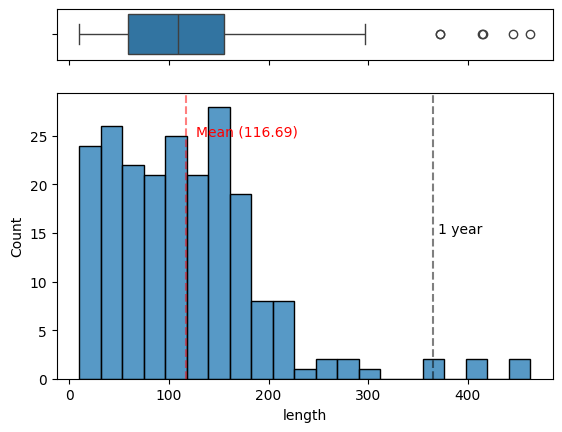

In [55]:
q4b_df_2 = q4b_df[q4b_df['length'] > 8]
mean_length = q4b_df_2['length'].mean()
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(q4b_df_2["length"], orient="h", ax=ax_box)
sns.histplot(data=q4b_df_2, x="length", bins=int(np.sqrt(q4b_df_2['length'].max())), ax=ax_hist)
plt.axvline(x = 365, color = 'black', alpha=0.5, linestyle='dashed')
plt.text(370,15, '1 year', color='black')
plt.axvline(x = mean_length, color='red', alpha=0.5, linestyle='dashed')
plt.text(mean_length+10, 25, f'Mean ({mean_length:.2f})', color='red')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Q5: How many customers have churned straight after their initial free trial - what percentage is this rounded to the nearest whole number?

In [42]:
query('''
    WITH num_customers AS(
        SELECT COUNT(DISTINCT customer_id) AS num_customers
        FROM subscriptions 
    ),
    p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
    )   
    SELECT
        COUNT(DISTINCT p4.customer_id) AS churned_count,
        ROUND(COUNT(DISTINCT p4.customer_id) / CAST(num_customers AS FLOAT) * 100,0) || ' %' AS percentage
        FROM num_customers, p4_dates p4
            INNER JOIN p0_dates p0 ON p4.customer_id = p0.customer_id
        WHERE
            julianday(p4.start_date) - julianday(p0.start_date) <= 8 --Churned straight after initial free trial
''')

,churned_count,percentage
0,93,9.0 %


- Note: Of the 93 customers, one (1) churned 8 days after the start of free trial, and the rest (92) churned 7 days after free trial.

Q6: What is the number and percentage of customer plans after their initial free trial?

Q7: What is the customer count and percentage breakdown of all 5 plan_name values at 2020-12-31?

Q8: How many customers have upgraded to an annual plan in 2020?

Q9: How many days on average does it take for a customer to an annual plan from the day they join Foodie-Fi?

Q10: Can you further breakdown this average value into 30 day periods (i.e. 0-30 days, 31-60 days etc)

Q11: How many customers downgraded from a pro monthly to a basic monthly plan in 2020?

**C. Challenge Payment Question**

Q12: The Foodie-Fi team wants you to create a new payments table for the year 2020 that includes amounts paid by each customer in the subscriptions table with the following requirements:

- monthly payments always occur on the same day of month as the original start_date of any monthly paid plan
- upgrades from basic to monthly or pro plans are reduced by the current paid amount in that month and start immediately
- upgrades from pro monthly to pro annual are paid at the end of the current billing period and also starts at the end of the month period
- once a customer churns they will no longer make payments

**D. Additional Questions (Open-Ended)**

Q13: How would you calculate the rate of growth for Foodie-Fi?

Q14: What key metrics would you recommend Foodie-Fi management to track over time to assess performance of their overall business?

Q15: What are some key customer journeys or experiences that you would analyse further to improve customer retention?

Q16: If the Foodie-Fi team were to create an exit survey shown to customers who wish to cancel their subscription, what questions would you include in the survey?

Q17: What business levers could the Foodie-Fi team use to reduce the customer churn rate? How would you validate the effectiveness of your ideas?
Conclusion